# 2022 EY Data Science Challenge 1

## Local Frog Discovery Tool

In this challenge, we will be developing a Species Distribution Model (SDM) for one Australian frog species using variables from the [TerraClimate](https://planetarycomputer.microsoft.com/dataset/terraclimate) dataset. A species distribution model is a specific type of machine learning model that aims to predict the distribution of a biological species across geographic space and time. Such models have become increasingly important in conservation efforts globally to better understand and map the habitats of species of interest, particularly threatened or endangered species. 

The frog species identified for this challenge is Litoria fallax, the eastern dwarf tree frog pictured below. In addition to assisting our understanding of this specific frog species, a successful frog SDM will have broader implications in quantifying biodiversity. This is because frogs are incredibly sensitive to environmental changes, so any changes in their species distribution may indicate an underlying change to biodiversity in the area.

<br>

<center>
<img src="Litoria_fallax.jpg" width="500" height="340">
</center>

<br>

We will predict the distribution in Australian regions at coarse resolution for the Litoria Fallax species against the rest of the 5 specified Australian species. Below we present the **TerraClimate dataset**, which we will use as our predictor variables:

### Dimensions

The dataset includes the following dimensions for coordinate labels.

| Name | Type | Description | Axis | Extent |
|----------------|------|-------------|------|--------|
| Lat  |  Spatial  |  Latitude     | y | -90, 90|
| Lon  |  Spatial  |  Longtitude   | x | -180, 180|
| Time |  Temporal |  Time         | t | 1958-01-01, 2019-12-01


### Variables

The dataset includes the following data variables.

| Name | Description | Unit | Dimensions | Shape | Chunks |
|------|-------------|------|------------|-------|--------|
| Q    | Runoff Amount | mm | (time, lat, lon) | (744, 4320, 8640) | (12, 1440, 1440) | 
| Ws   | 10-m Wind Speed | m/s | (time, lat, lon) | (744, 4320, 8640) | (12, 1440, 1440) | 
| Aet  | Actual Water Evapotranspiration | mm | (time, lat, lon) | (744, 4320, 8640) | (12, 1440, 1440) | 
| Def  | Climatic Water Deficit | mm | (time, lat, lon) | (744, 4320, 8640) | (12, 1440, 1440) | 
| Pet  | Reference Evapotranspiration  | mm | (time, lat, lon) | (744, 4320, 8640) | (12, 1440, 1440) | 
| Ppt  | Accumulated Precipitation  | mm | (time, lat, lon) | (744, 4320, 8640) | (12, 1440, 1440) | 
| Swe  | Snow Water Equivalent at End of Month | mm | (time, lat, lon) | (744, 4320, 8640) | (12, 1440, 1440) | 
| Vap  | 2-m Water Vapor Pressure | kPa | (time, lat, lon) | (744, 4320, 8640) | (12, 1440, 1440) | 
| Vpd  | Mean Vapor Pressure Deficit | kPa | (time, lat, lon) | (744, 4320, 8640) | (12, 1440, 1440) | 
| Pdsi | Palmer Drought Severity Index | - | (time, lat, lon) | (744, 4320, 8640) | (12, 1440, 1440) | 
| Soil | Soil Moisture Content at End of Month | mm | (time, lat, lon) | (744, 4320, 8640) | (12, 1440, 1440) | 
| Srad | Downward Shortwave Radiation Flux at the Surface | W/$\text{m}^{2}$ | (time, lat, lon) | (744, 4320, 8640) | (12, 1440, 1440) | 
| Tmax | Maximum 2-m Temperature | deg C | (time, lat, lon) | (744, 4320, 8640) | (12, 1440, 1440) | 
| Tmin | Minimum 2-m Temperature | deg C | (time, lat, lon) | (744, 4320, 8640) | (12, 1440, 1440) | 
| Ppt_station_influence  | Influence* | - | (time, lat, lon) | (744, 4320, 8640) | (12, 1440, 1440) | 
| Vap_station_influence  | Influence* | - | (time, lat, lon) | (744, 4320, 8640) | (12, 1440, 1440) | 
| Tmax_station_influence | Influence* | - | (time, lat, lon) | (744, 4320, 8640) | (12, 1440, 1440) | 
| Tmin_station_influence | Influence* | - | (time, lat, lon) | (744, 4320, 8640) | (12, 1440, 1440) | 

*
**Influence:** A number between 0 and 8, indicating the number of stations contributing to each grid value directly from CRU and interpolated to the TerraClimate grid. When this value is greater than 1, CRU data is used for the anomalies in the method. When this value is 0, JRA-55/ERA-20C/ERA-INTERIM is used for anomalies in the method.


## Load in dependencies

In [1]:
# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')

# Plotting
import matplotlib.pyplot as plt

# Data science
import pandas as pd
import numpy as np

# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold

# Geospatial
import contextily as cx
import xarray as xr
import zarr # Not referenced, but required for xarray

# Import Planetary Computer tools
import fsspec
import pystac

# Other
import os
import zipfile
from itertools import cycle
import wget

# Path to data folder with provided material
output_path = './output/'

import folium
import tqdm

## Create frog occurence data (response variable)
Our response variable includes samples from 5 frog species' occurrences in Australia.

In [2]:
# Download training data
url = 'https://github.com/EY-Data-Science-Program/2022-Better-Working-World-Data-Challenge/blob/c155650e471a795d6ade4f4bf165f5d2aed0207c/notebooks/GBIF_training_data.zip?raw=true'
if not os.path.exists('GBIF_training_data.zip'):
    filename = wget.download(url)
    
# Unzip training data
if not os.path.exists('training_data/'):
    os.mkdir('training_data/')
    with zipfile.ZipFile('GBIF_training_data.zip', 'r') as zip_ref:
        zip_ref.extractall('training_data/')

# Function to constrain our search area
def filter_bbox(frogs, bbox):
    frogs = frogs[lambda x: 
        (x.decimalLongitude >= bbox[0]) &
        (x.decimalLatitude >= bbox[1]) &
        (x.decimalLongitude <= bbox[2]) &
        (x.decimalLatitude <= bbox[3])
    ]
    return frogs

def filter_bboxes(all_frogs, bbox):
    list_dfs=[]
    box = bbox[0]
    frogs = filter_bbox(all_frogs, box)
    list_dfs.append(frogs)
    for box in bbox[1:]:
        x_frogs = filter_bbox(all_frogs, box)
        frogs = pd.concat([frogs, x_frogs])
        list_dfs.append(x_frogs)
    return frogs, list_dfs
        
# year_range: parameter to constrain our search time span
def get_frogs(file, year_range=None, bbox=None):
    """Returns the dataframe of all frog occurrences for the bounding box specified."""
    columns = [
        'gbifID','eventDate','country','continent','stateProvince',
        'decimalLatitude','decimalLongitude','species'
    ]
    country_names = {
        'AU':'Australia', 'CR':'Costa Rica', 'ZA':'South Africa','MX':'Mexico','HN':'Honduras',
        'MZ':'Mozambique','BW':'Botswana','MW':'Malawi','CO':'Colombia','PA':'Panama','NI':'Nicaragua',
        'BZ':'Belize','ZW':'Zimbabwe','SZ':'Eswatini','ZM':'Zambia','GT':'Guatemala','LS':'Lesotho',
        'SV':'El Salvador', 'AO':'Angola', np.nan:'unknown or invalid'
    }
    continent_names = {
        'AU':'Australia', 'CR':'Central America', 'ZA':'Africa','MX':'Central America','HN':'Central America',
        'MZ':'Africa','BW':'Africa','MW':'Africa','CO':'Central America','PA':'Central America',
        'NI':'Central America','BZ':'Central America','ZW':'Africa','SZ':'Africa','ZM':'Africa',
        'GT':'Central America','LS':'Africa','SV':'Central America','AO':'Africa', np.nan:'unknown or invalid' 
    }
    frogs = (
        pd.read_csv('training_data/occurrence.txt', sep='\t', parse_dates=['eventDate'])
        .assign(
            country =  lambda x: x.countryCode.map(country_names),
            continent =  lambda x: x.countryCode.map(continent_names),
            species = lambda x: x.species.str.title()
        )
        [columns]
    )
    if year_range is not None:
        frogs = frogs[lambda x: 
            (x.eventDate.dt.year >= year_range[0]) & 
            (x.eventDate.dt.year <= year_range[1])
        ]
    if bbox is not None:
        frogs, list_dfs = filter_bboxes(frogs, bbox)
    else:
        list_dfs = None
    return frogs, list_dfs

## Australia frog occurences in space

In [3]:
data, _ = get_frogs('training_data/occurrence.txt')

species_colourmap = {species:colour['color'] for species, colour in zip(data.species.value_counts().index, cycle(plt.rcParams['axes.prop_cycle']))}

def plot_species(fig, ax, frog_data, region_name='region_name', colourmap=None):
    # Bar chart
    bar_data = frog_data.species.value_counts()
    barchart = ax[1].bar(bar_data.index.str.replace(' ', '\n'), bar_data)
    
    # Colour cycle to ensure colors match in both plots
    if colourmap is None:
        colourmap = {species:colour['color'] for species, colour in zip(frog_data.species.value_counts().index, cycle(plt.rcParams['axes.prop_cycle']))}
    for i in range(len(bar_data)):
        species_name = bar_data.index[i]
        if len(species_name) > 19:
            display_name = species_name.replace(' ', '\n')
        else:
            display_name = species_name
        barchart[i].set_color(colourmap[species_name])
        barchart[i].set_label(f"{display_name}\nCount: {bar_data[i]}")
        filt = frog_data.species == species_name
        
        # Scatter plot
        ax[0].scatter(
            frog_data[filt].decimalLongitude, 
            frog_data[filt].decimalLatitude, 
            marker='.', 
            color=colourmap[species_name]
        )
    # Add other features
    ax[0].set_title(f"Frog occurrences for {region_name}")
    ax[0].set_xticklabels([])
    ax[0].set_yticklabels([])
    ax[1].set_title(f"Frog species distribution in {region_name}")
    cx.add_basemap(ax[0], crs={'init':'epsg:4326'}, alpha=0.5) # Add basemap
    ax[1].set_xticklabels(bar_data.index.str.replace(' ', '\n'), rotation=45)
    ax[1].legend()

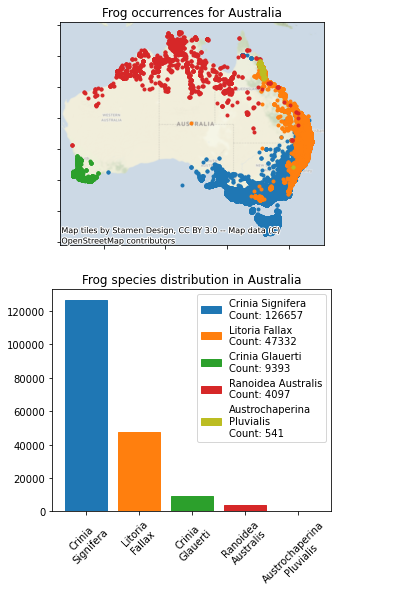

In [4]:
fig, ax = plt.subplots(2, 1, figsize=(5, 9))
filt = data.continent == 'Australia'
plot_species(fig, ax, data[filt], 'Australia', colourmap=species_colourmap)
plt.show()

## Sampling bias
Frog occurrences in our response variable are heavily biased around urban areas, where people are more likely to come across them. As a result, we have samples only around those areas. To address this problem, we are going to use the occurrence points of other species as absence points for the target species. This is called pseudo-absence and is a common technique in species distribution modelling. This way, if a different species of frog has been sighted in a specific location, we can be more certain that the species we are trying to predict is not at that same location.

## Australia frog occurences through time

Text(0.5, 1.0, 'Frogs over time by species')

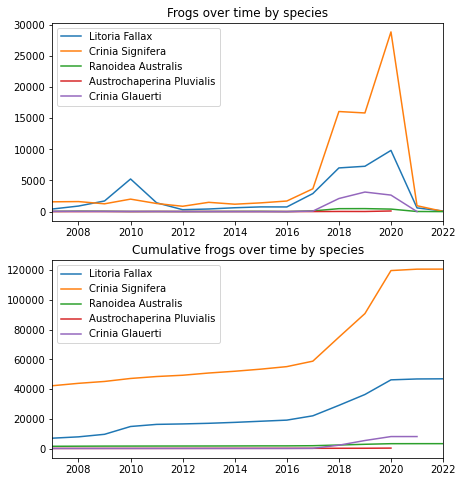

In [5]:
fig, ax = plt.subplots(2, 1, figsize=(7, 8))
cnt = 'Australia'
country_data = data[data.country == cnt]    
for species in country_data.species.unique():
    plot_data = country_data[lambda x: x.species == species]
    line_data = (
        plot_data
        [['eventDate']]
        .dropna()
        .assign(
            year = lambda x: x.eventDate.dt.year,
            n = 1
        )
        .groupby('year')
        .sum()
        .reset_index()
        .sort_values('year')
        .assign(ncum=lambda x: x.n.cumsum())
    )
    ax[1].plot(line_data.year, line_data.ncum, label=species)
    ax[0].plot(line_data.year, line_data.n, label=species)
    # ax[0, i].hist(plot_data.eventDate.dt.year, alpha=0.5, label=species, density=True, bins=list(range(1900, 2025, 10)))
xlim = (2007, 2022)
# xlim = (country_data.eventDate.dt.year.min(), country_data.eventDate.dt.year.max()) 
ax[1].legend(loc='upper left')
ax[1].set_xlim(xlim)
ax[1].set_title(f"Cumulative frogs over time by species")
ax[0].legend(loc='upper left')
ax[0].set_xlim(xlim)
ax[0].set_title(f"Frogs over time by species")

## Spatial & Temporal sampling
We need to sample an adequate amount of samples, both from the target species and the non-target ones, but also create a balanced dataset between the two. Below, we choose to sample around some Australian cities, including Sydney, Melbourne and Perth.

In [6]:
region_name = 'Australia' # TODO: fix

minmaxlonlat = [(115.9, -32.2,116.15, -31.8),  # perth
                (145.2, -17.9,145.97, -16.47), # cairns
                (152.3, -29.2,153.6, -26.9),   # gold coast
                (151.0, -33.1,151.6, -32.2),   # sydney
                (145.0, -38.0,145.4, -37.4)]   # melbourne
bboxes = [(min_lon, min_lat, max_lon, max_lat) for (min_lon, min_lat, max_lon, max_lat) in minmaxlonlat]

# Load in data                                                            #could also use (2008, 2012)
all_frog_data, list_dfs = get_frogs('training_data/occurrence.txt', year_range=(2015, 2019), bbox=bboxes)
all_frog_data.head()

,gbifID,eventDate,country,continent,stateProvince,decimalLatitude,decimalLongitude,species
4735,3463456328,2019-09-08,Australia,Australia,Western Australia,-31.871200,115.907000,Crinia Glauerti
4785,3463456511,2019-08-23,Australia,Australia,Western Australia,-31.933100,115.909000,Crinia Glauerti
4790,3463456527,2019-08-31,Australia,Australia,Western Australia,-31.926800,115.921000,Crinia Glauerti
4806,3463456577,2018-10-23,Australia,Australia,Western Australia,-31.969100,116.130000,Crinia Glauerti
4882,3463456876,2018-09-09,Australia,Australia,Western Australia,-32.084917,115.940745,Crinia Glauerti


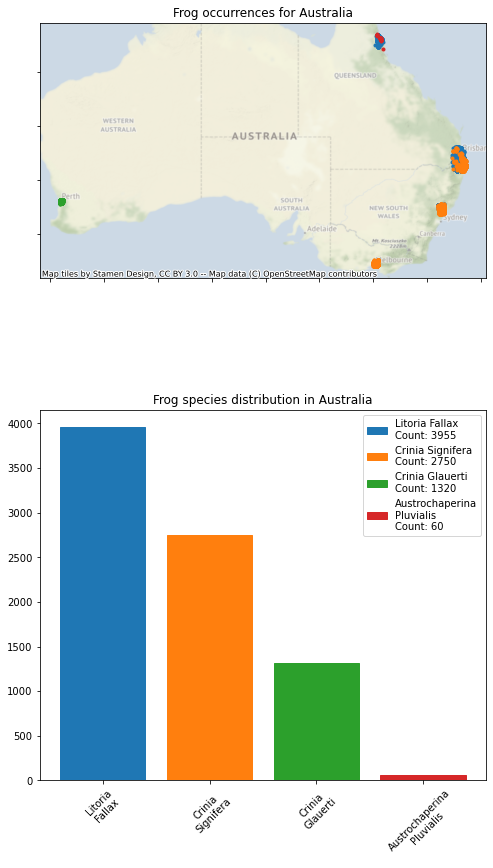

In [7]:
fig, ax = plt.subplots(2, 1, figsize=(8, 15))
plot_species(fig, ax, all_frog_data, region_name)

We will alter our response variable to be `occurenceStatus` which will take the value of 1 if the occurrence species is litoria fallax, and 0 if the species is not litoria fallax

In [8]:
list_dfss = []
target_species = 'Litoria Fallax'
for list_df in list_dfs:
    list_df  = (
    list_df 
    # Assign the occurrenceStatus to 1 for the target species and 0 for all other species.
    # as well as a key for joining (later)
    .assign(
        occurrenceStatus = lambda x: np.where(x.species == target_species, 1, 0))
)
    list_df = list_df.reset_index(drop=True).assign(key=lambda x: x.index)
    list_dfss.append(list_df)
list_frog_dfs = list_dfss

In [9]:
all_frog_data = (
    all_frog_data
    # Assign the occurrenceStatus to 1 for the target species and 0 for all other species.
    # as well as a key for joining (later)
    .assign(
        occurrenceStatus = lambda x: np.where(x.species == target_species, 1, 0)
    )
)
frog_data = all_frog_data.copy()

## Predictor Variables

Now that we have our response variable, it is time to gather the predictor variables from the TerraClimate dataset. 

To assist in visualisations, this function has an interpolation functionality which will allow the comparitively coarse temporal resolution of the terraclimate data to be mapped to a larger set of coordinates, creating an ($n$ x $m$) image. We will choose (512 x 512).

In [11]:
def get_terraclimate(bbox, metrics, time_slice=None, assets=None, features=None, interp_dims=None, verbose=True):
    """Returns terraclimate metrics for a given area, allowing results to be interpolated onto a larger image.
    
    Attributes:
    bbox -- Tuple of (min_lon, min_lat, max_lon, max_lat) to define area
    metrics -- Nested dictionary in the form {<metric_name>:{'fn':<metric_function>,'params':<metric_kwargs_dict>}, ... }
    time_slice -- Tuple of datetime strings to select data between, e.g. ('2015-01-01','2019-12-31')
    assets -- list of terraclimate assets to take
    features -- list of asset metrics to take, specified by strings in the form '<asset_name>_<metric_name>'
    interp_dims -- Tuple of dimensions (n, m) to interpolate results to
    """
    min_lon, min_lat, max_lon, max_lat = bbox
    
    collection = pystac.read_file("https://planetarycomputer.microsoft.com/api/stac/v1/collections/terraclimate")
    asset = collection.assets["zarr-https"]
    store = fsspec.get_mapper(asset.href)
    data = xr.open_zarr(store, **asset.extra_fields["xarray:open_kwargs"])
    
    # Select datapoints that overlap region
    if time_slice is not None:
        data = data.sel(lon=slice(min_lon,max_lon),lat=slice(max_lat,min_lat),time=slice(time_slice[0],time_slice[1]))
    else:
        data = data.sel(lon=slice(min_lon,max_lon),lat=slice(max_lat,min_lat))
    if assets is not None:
        data = data[assets]
#     print('Loading data') if verbose else None
    data = data.rename(lat='y', lon='x').to_array().compute()
        
    # Calculate metrics
    combined_values = []
    combined_bands = []
    for name, metric in metrics.items():
#         print(f'Calculating {name}') if verbose else None
        sum_data = xr.apply_ufunc(
            metric['fn'], data, input_core_dims=[["time"]], kwargs=metric['params'], dask = 'allowed', vectorize = True
        ).rename(variable='band')
        xcoords = sum_data.x
        ycoords = sum_data.y
        dims = sum_data.dims
        combined_values.append(sum_data.values)
        for band in sum_data.band.values:
            combined_bands.append(band+'_'+name)
        
    # Combine metrics
    combined_values = np.concatenate(
        combined_values,
        axis=0
    )
    combined_data = xr.DataArray(
        data=combined_values,
        dims=dims,
        coords=dict(
            band=combined_bands,
            y=ycoords,
            x=xcoords
        )
    )    

    # Take relevant bands:
    combined_data = combined_data.sel(band=features)
    
    if interp_dims is not None:
#         print(f'Interpolating image') if verbose else None
        interp_coords = (np.linspace(bbox[0], bbox[2], interp_dims[0]), np.linspace(bbox[1], bbox[3], interp_dims[1]))
        combined_data = combined_data.interp(x=interp_coords[0], y=interp_coords[1], method='nearest', kwargs={"fill_value": "extrapolate"})
    return combined_data

In [12]:
# Metrics to measure over time dimension
tc_metrics = {
    'mean':{
        'fn':np.nanmean,
        'params':{}
    },
    'min':{
        'fn':np.nanmin,
        'params':{}
    },
    'max':{
        'fn':np.nanmax,
        'params':{}
    }}

# Date range to take
time_slice = ('2015-01-01','2019-12-31')
assets=['q','ws','aet','def','pet','swe','vap','vpd','pdsi','srad','tmax', 'tmin', 'ppt', 'soil',]
features=['q_mean','ws_mean','aet_mean','def_mean','pet_mean','swe_mean','vap_mean','vpd_mean','pdsi_mean',
          'srad_mean','tmax_mean', 'tmin_mean', 'ppt_mean', 'soil_mean']
# Interpolate values to a 512x512 image
interp_dims = (512, 512)

list_weather = []
for bbox in tqdm.tqdm(bboxes):
    weather_data = get_terraclimate(bbox, tc_metrics, time_slice=time_slice, assets=assets, features=features, interp_dims=interp_dims)
    list_weather.append(weather_data)
    #display(weather_data.band.values)

100%|████████████████████████████████████████████| 5/5 [12:03<00:00, 144.77s/it]


### Visualising the TerraClimate Data
The spatial distribution of the four variables are displayed below.

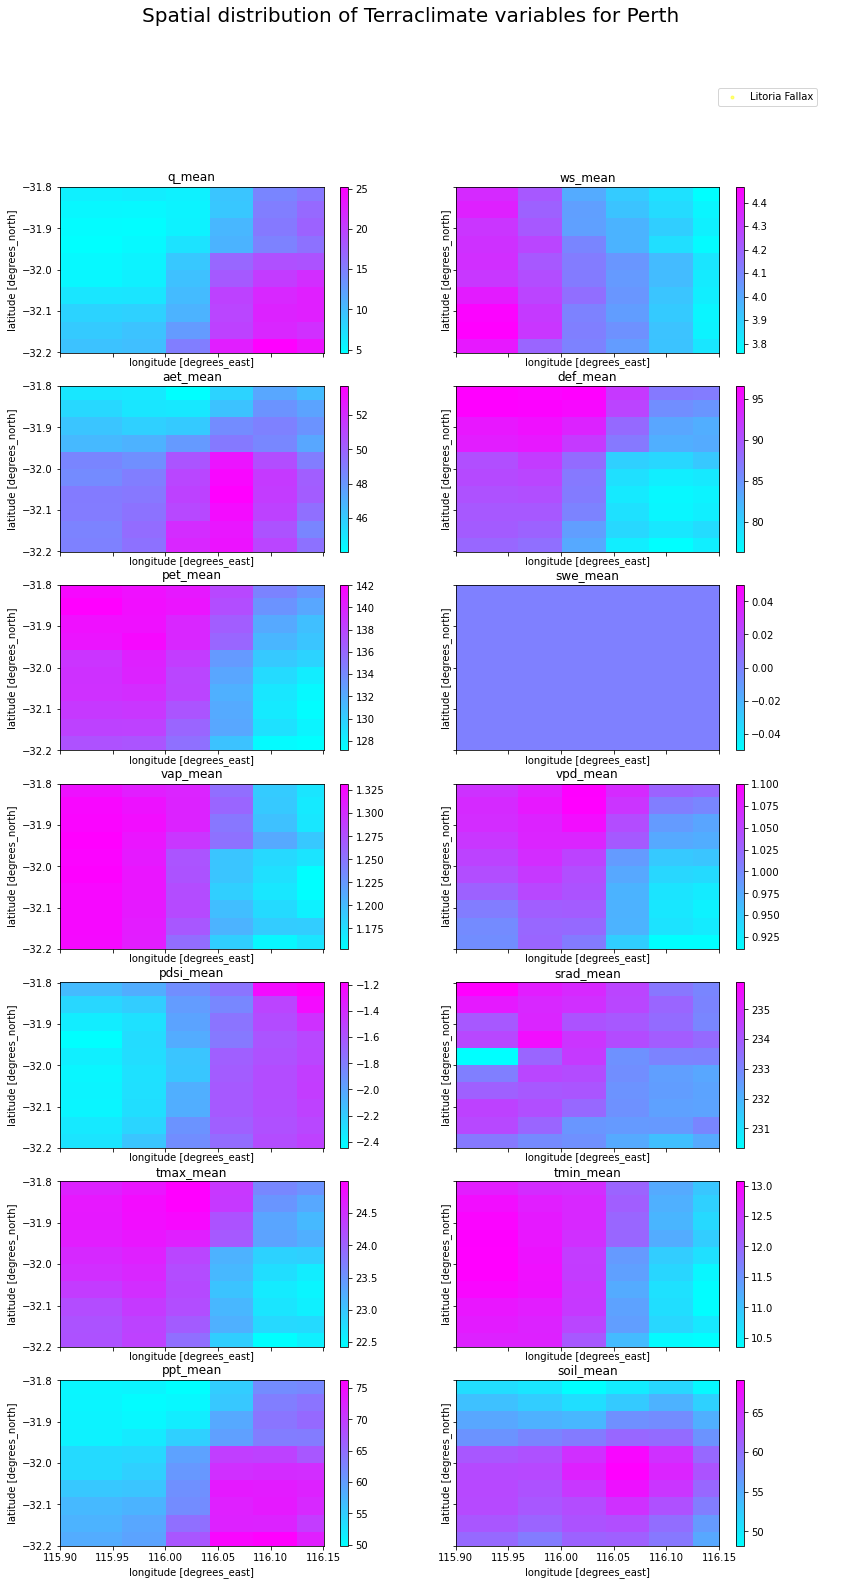

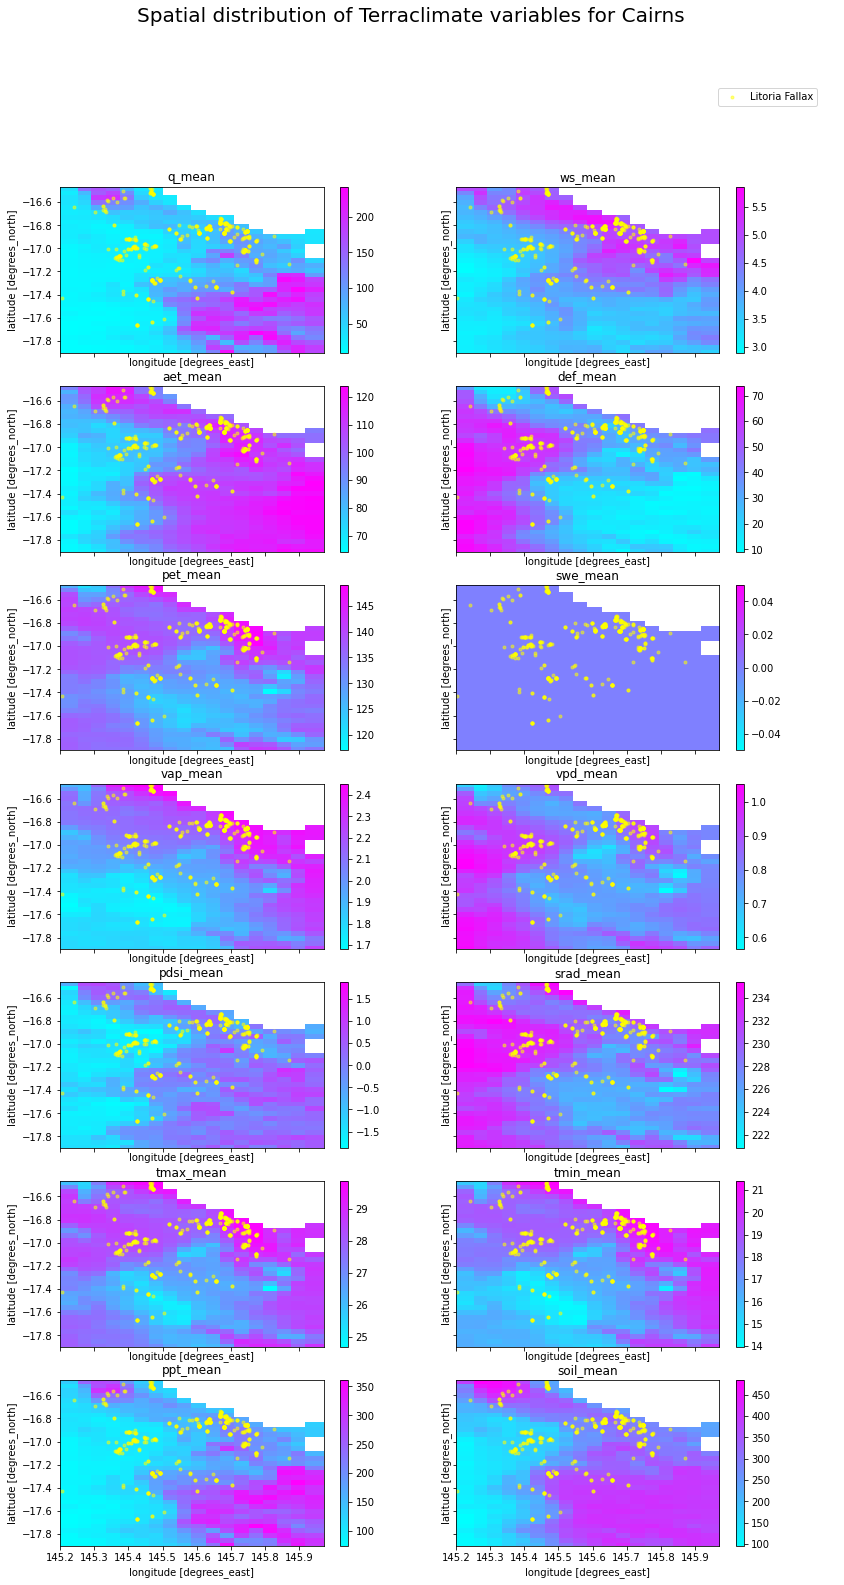

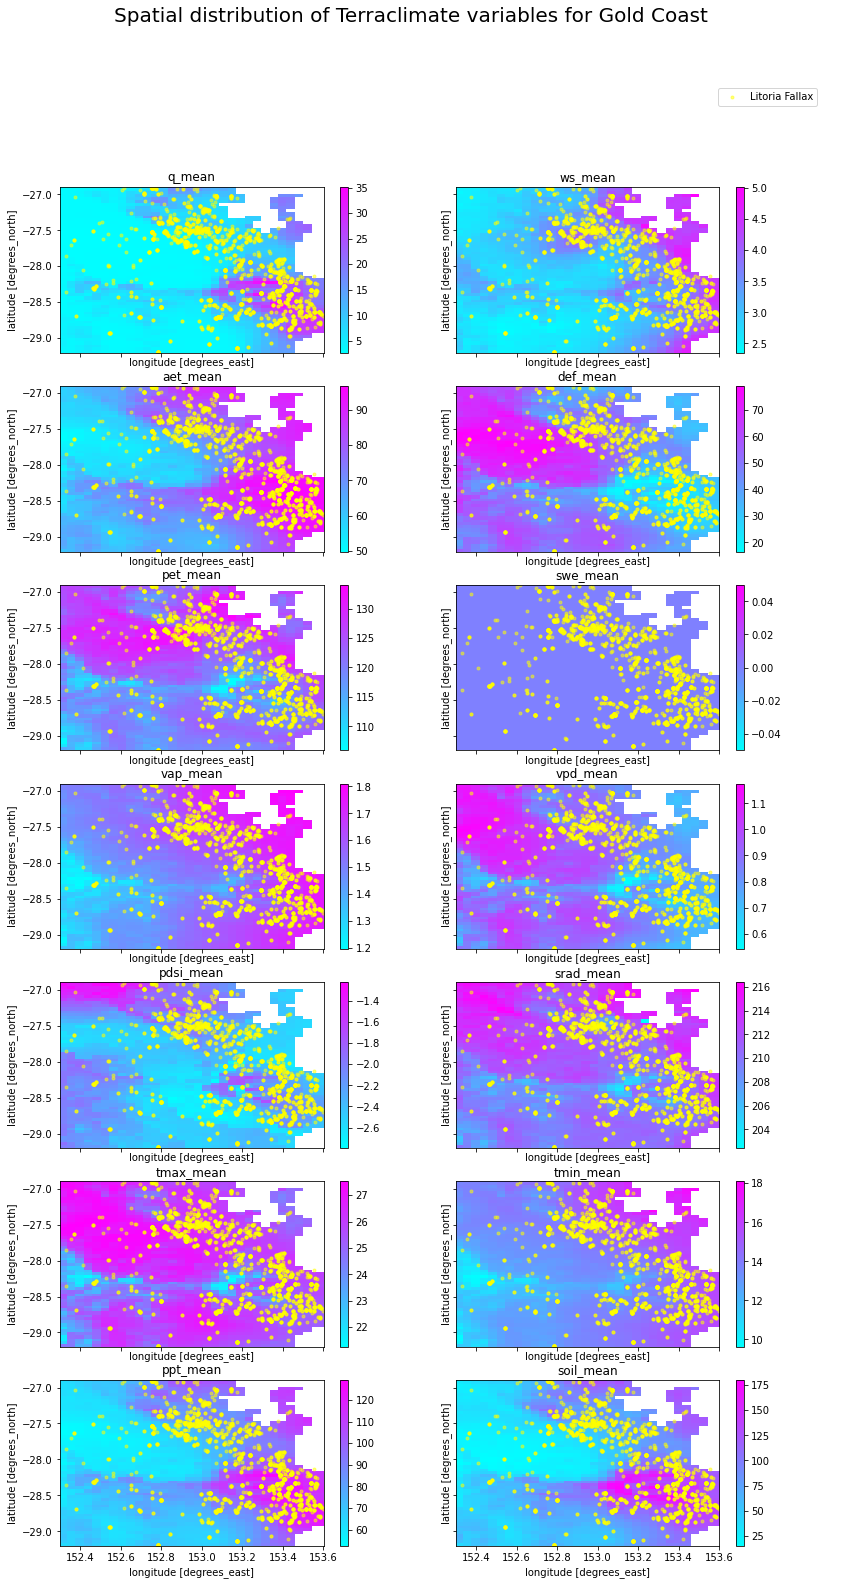

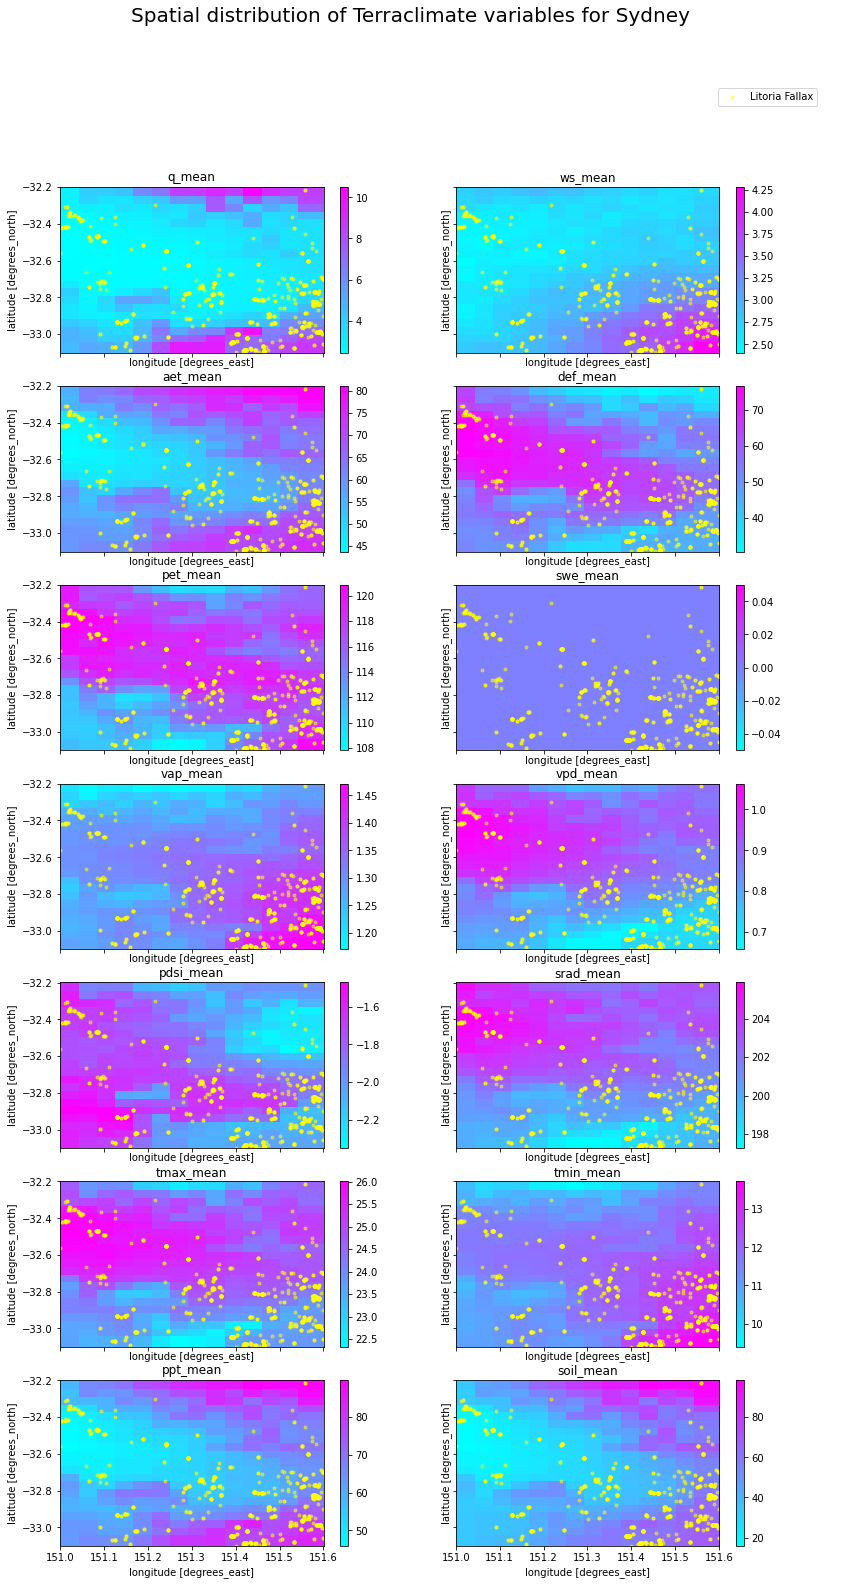

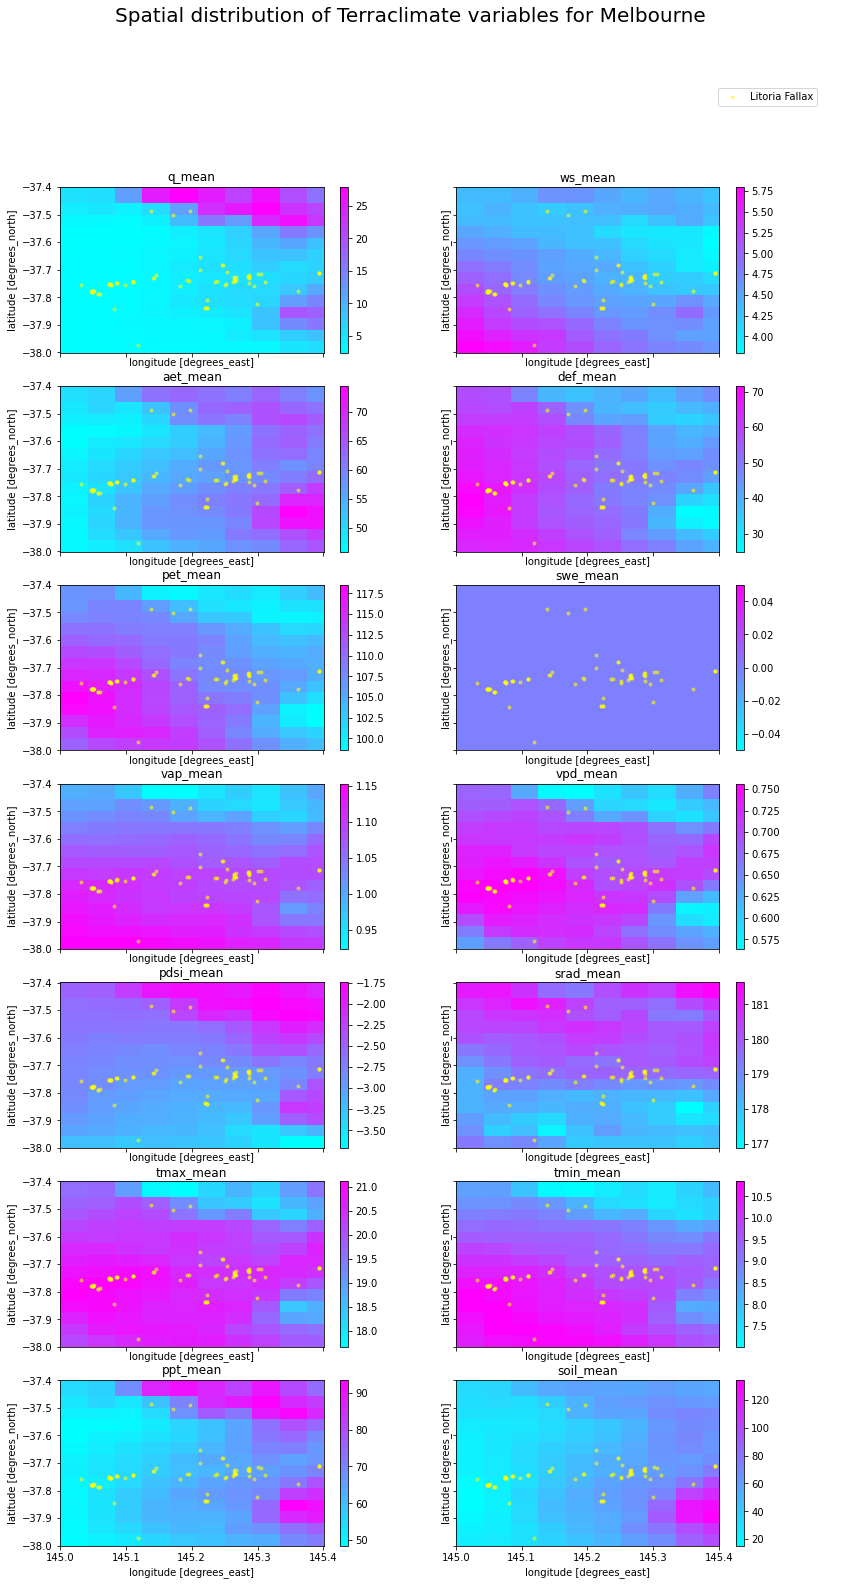

In [13]:
areas = ["Perth", "Cairns", "Gold Coast", "Sydney", "Melbourne"]
for (weather_data, area, list_frog_df) in zip(list_weather, areas, list_frog_dfs):
    nrow = 7
    ncol = 2
    fig, ax = plt.subplots(nrow, ncol, figsize=(13, 25), sharex=True, sharey=True)

    bands = weather_data.band.values
    filt = list_frog_df.occurrenceStatus == 1
    cmaps = ["cool" for _ in range(14)]

    for i in range(len(bands)):
        xr.plot.imshow(weather_data[i], 'x', 'y', ax=ax[i//ncol, i%ncol],cmap=cmaps[i])
        ax[i//ncol, i%ncol].set_title(bands[i])
        ax[i//ncol, i%ncol].scatter(list_frog_df[filt].decimalLongitude, list_frog_df[filt].decimalLatitude,
                                    color = 'yellow', marker='.', alpha=0.5, label=target_species if i==0 else '')

    fig.suptitle("Spatial distribution of Terraclimate variables for " + area, fontsize=20)
    fig.legend(loc=(0.85, 0.933))

From the plots above, we can determine which predictor variables to use to train our model, to have a clear image of our target species occurence. We will avoid choosing variables, whose values vary in our species distribution space and look for consistency accross the different Australian cities.

### Feature engineering
The frequency distribution of each variable is displayed below. There is some skewness present in a few variables, so you might want to address this when training your own model. Depending on the type of model you decide to train, some of the variables might require normalisation, standardisation, or transformation. For now, we will proceed with the variables as they come.

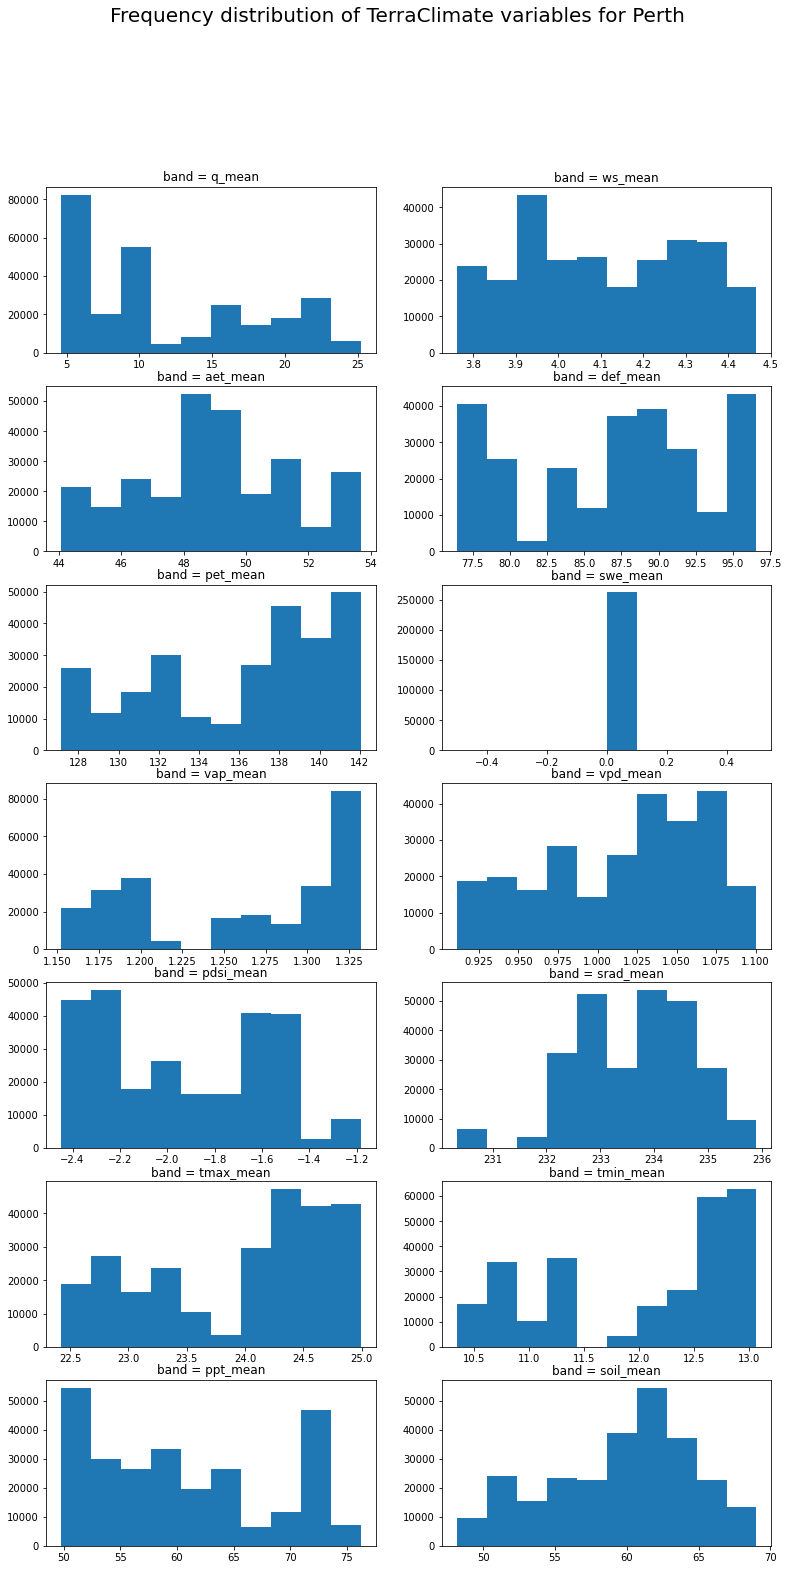

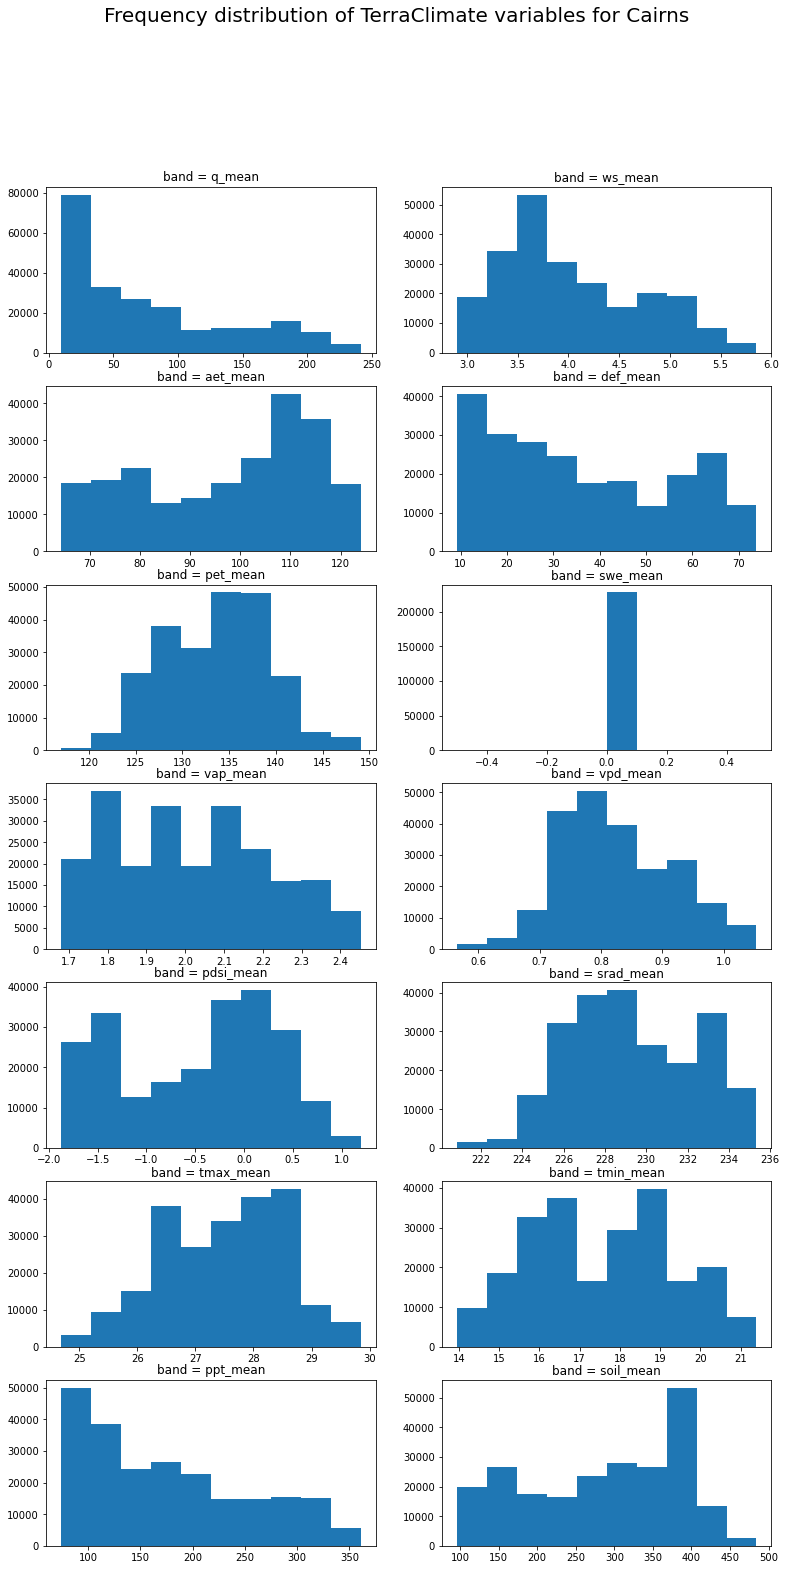

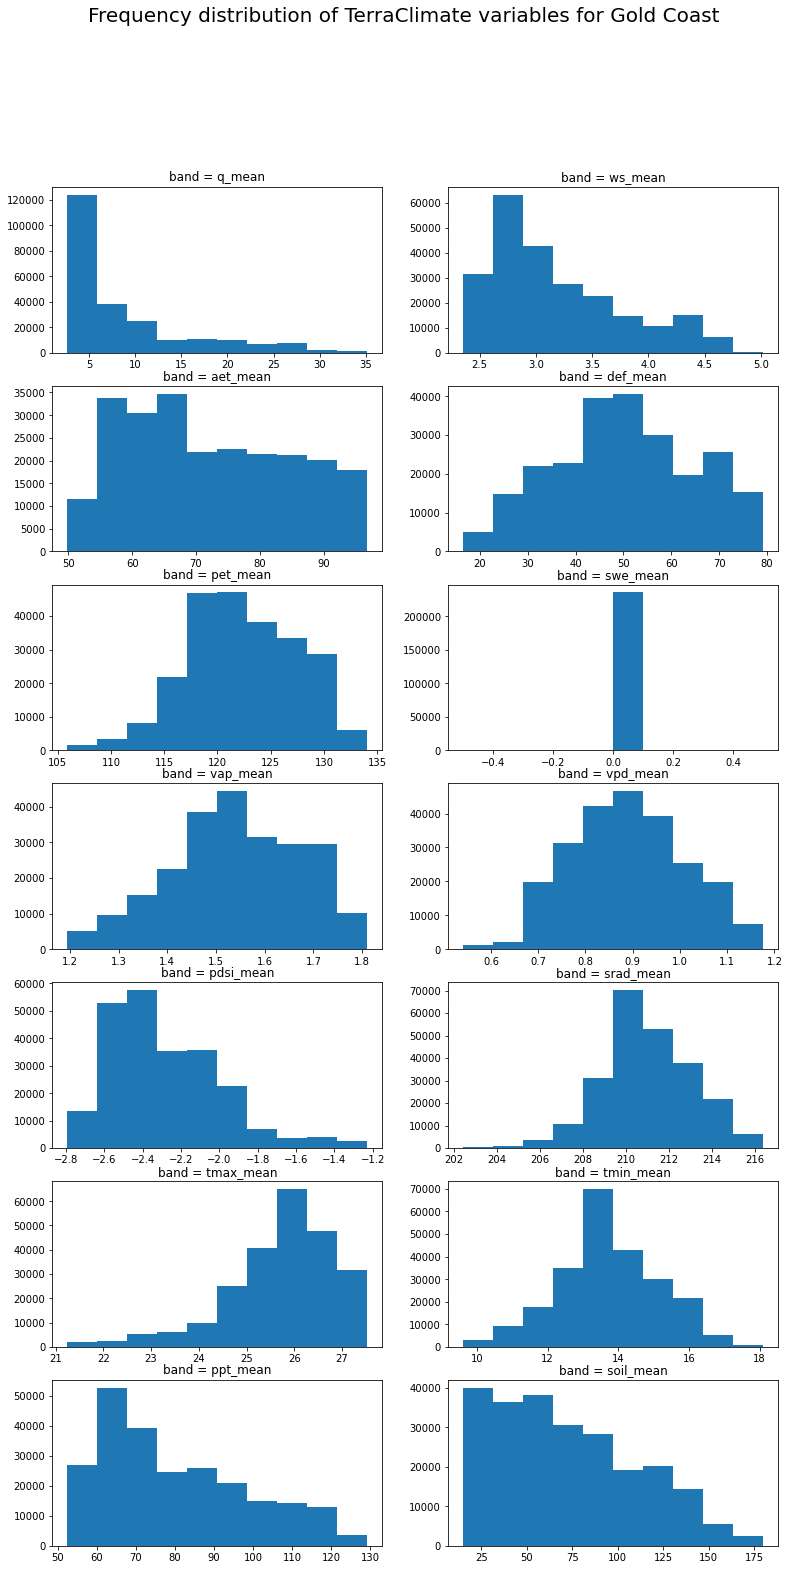

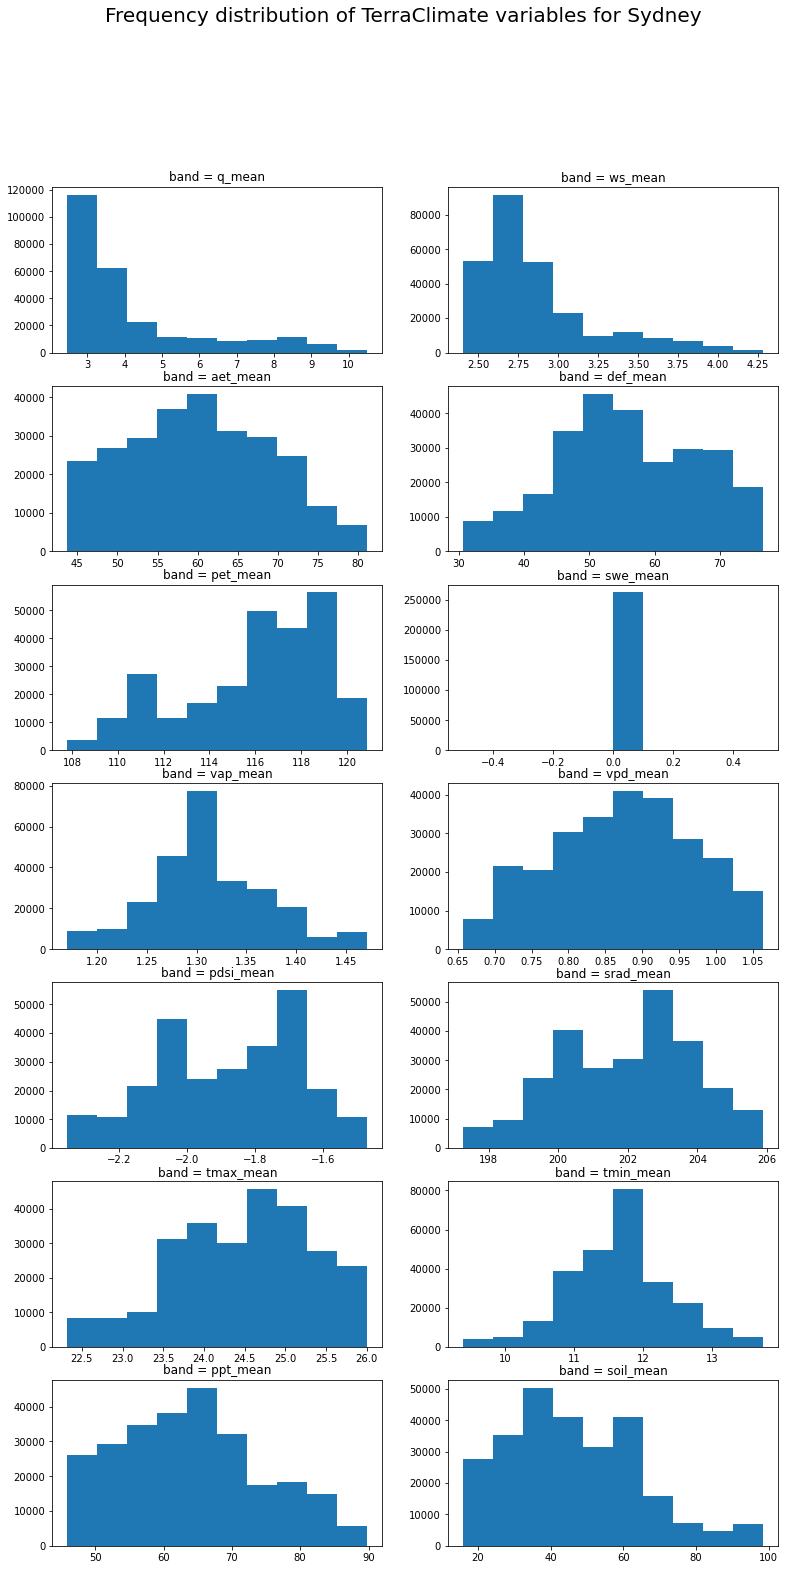

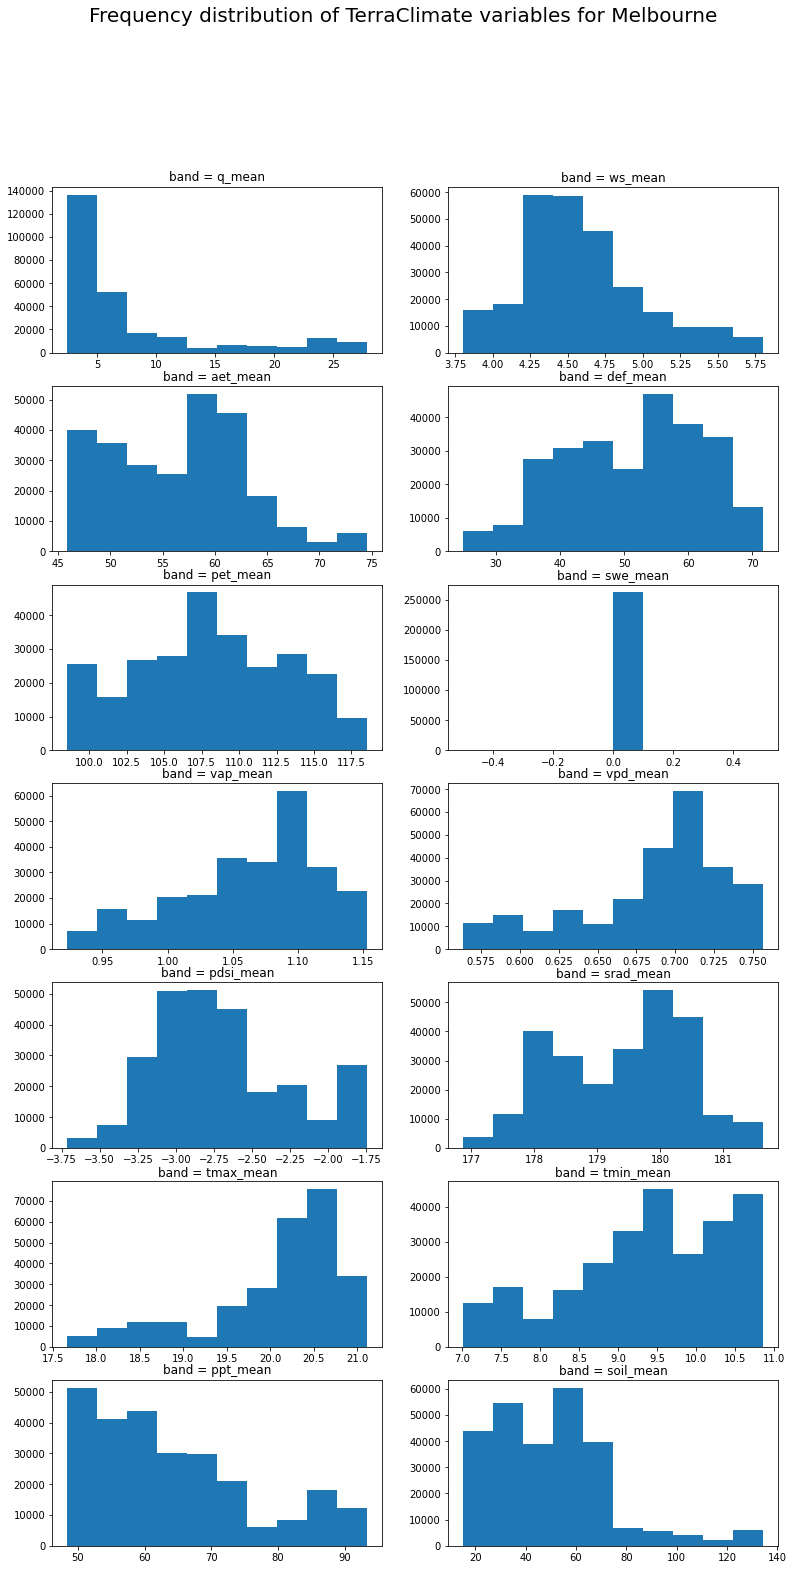

In [14]:
for (weather_data, area) in zip(list_weather, areas):
    nrow = 7
    ncol = 2
    fig, ax = plt.subplots(nrow, ncol, figsize=(13, 25))

    bands = weather_data.band.values

    for i in range(len(bands)):
        xr.plot.hist(weather_data[i], ax=ax[i//ncol, i%ncol])

    fig.suptitle("Frequency distribution of TerraClimate variables for " + area,  fontsize=20)

In [15]:
# 'tmax_mean', 'tmin_mean','vap_mean', 'pet_mean'

### Joining Predictors to the Response Variable

Now that we have read in our predictor variables, we need to join them onto the response variable of frogs. To do this, we loop through the frog occurrence data and assign each frog occurrence the closest predictor pixel value from each of the predictor variables based on the geo-coordinates. The `sel` method of the xarray dataarray comes in handy here.

In [16]:
def join_frogs(frogs, data):
    """Collects the data for each frog location and joins it onto the frog data 

    Arguments:
    frogs -- dataframe containing the response variable along with ["decimalLongitude", "decimalLatitude", "key"]
    data -- xarray dataarray of features, indexed with geocoordinates
    """
    return frogs.merge(
        (
            data
            .rename('data')
            .sel(
                  x=xr.DataArray(frogs.decimalLongitude, dims="key", coords={"key": frogs.key}),
                  y=xr.DataArray(frogs.decimalLatitude, dims="key", coords={"key": frogs.key}),
                method="nearest"
            )
            .to_dataframe()
            .assign(val = lambda x: x.iloc[:, -1])
            [['val']]
            .reset_index()
            .drop_duplicates()
            .pivot(index="key", columns="band", values="val")
            .reset_index()
        ),
        on = ['key'],
        how = 'inner'
    )


model_data = join_frogs(list_frog_dfs[0], list_weather[0])
for i, list_frog_df in enumerate(list_frog_dfs[1:]):
    model_data = pd.concat([model_data, join_frogs(list_frog_df, list_weather[i+1])], ignore_index=True)
model_data.head()

,gbifID,eventDate,country,continent,stateProvince,decimalLatitude,decimalLongitude,species,occurrenceStatus,key,...,ppt_mean,q_mean,soil_mean,srad_mean,swe_mean,tmax_mean,tmin_mean,vap_mean,vpd_mean,ws_mean
0,3463456328,2019-09-08,Australia,Australia,Western Australia,-31.871200,115.907000,Crinia Glauerti,0,0,...,50.833333,5.333333,53.250000,235.316667,0.0,24.750002,12.928335,1.327167,1.069167,4.373333
1,3463456511,2019-08-23,Australia,Australia,Western Australia,-31.933100,115.909000,Crinia Glauerti,0,1,...,51.200000,4.616667,56.966667,234.350000,0.0,24.696669,13.060002,1.332167,1.060500,4.331667
2,3463456527,2019-08-31,Australia,Australia,Western Australia,-31.926800,115.921000,Crinia Glauerti,0,2,...,51.200000,4.616667,56.966667,234.350000,0.0,24.696669,13.060002,1.332167,1.060500,4.331667
3,3463456577,2018-10-23,Australia,Australia,Western Australia,-31.969100,116.130000,Crinia Glauerti,0,3,...,67.216667,18.450000,60.500000,233.066667,0.0,22.910001,10.683335,1.172000,0.954000,3.835000
4,3463456876,2018-09-09,Australia,Australia,Western Australia,-32.084917,115.940745,Crinia Glauerti,0,4,...,57.083333,8.083333,63.050000,234.450000,0.0,24.223335,12.828335,1.325500,1.007333,4.453333


In [17]:
# Keep this variable for testing purposes
model_data_copy = model_data.copy()

### Mutual information between target species occurence for TerraClimate variables

In [18]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y):
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

X = model_data_copy.drop(['gbifID', 'eventDate', 'country', 'continent', 'stateProvince', 'decimalLatitude',
                     'decimalLongitude', 'species','occurrenceStatus', 'key'], 1)
y = model_data_copy.occurrenceStatus.astype(int)

nas = []
for na in X[X['tmax_mean'].isna()].index:
    X = X.drop(axis=0, index=na)
    nas.append(na)

for na in nas:
    y = y.drop(axis=0, index=na)

mi_scores = make_mi_scores(X, y)
mi_scores

tmin_mean    0.415382
tmax_mean    0.413100
ws_mean      0.411909
pet_mean     0.407820
vap_mean     0.407523
def_mean     0.403758
soil_mean    0.400326
pdsi_mean    0.395476
ppt_mean     0.395041
vpd_mean     0.392951
srad_mean    0.390607
aet_mean     0.390020
q_mean       0.362589
swe_mean     0.000000
Name: MI Scores, dtype: float64

In [19]:
# Separate the predictor variables from the response

# Specify which features to keep here like this
to_keep = ['tmin_mean', 'tmax_mean', 'vap_mean', 'pet_mean']

to_drop = ['gbifID', 'eventDate', 'decimalLatitude', 'decimalLongitude', 'species'
          ,'country', 'continent', 'stateProvince', 'occurrenceStatus', 'key'
          ,'tmin_mean', 'tmax_mean', 'vap_mean', 'pet_mean'
          ,'srad_mean', 'pdsi_mean',  'vpd_mean', 'aet_mean'
          , 'soil_mean', 'ppt_mean', 'def_mean' 
          ,'q_mean','swe_mean', 'ws_mean'
]

for feat in to_keep:
    to_drop.remove(feat)

print(to_drop)    

X = (model_data.drop(to_drop,1)).reset_index(drop=True)

nas = []
for na in X[X['vap_mean'].isna()].index:
    X = X.drop(axis=0, index=na)
    nas.append(na)

['gbifID', 'eventDate', 'decimalLatitude', 'decimalLongitude', 'species', 'country', 'continent', 'stateProvince', 'occurrenceStatus', 'key', 'srad_mean', 'pdsi_mean', 'vpd_mean', 'aet_mean', 'soil_mean', 'ppt_mean', 'def_mean', 'q_mean', 'swe_mean', 'ws_mean']


In [20]:
X_copy = X.copy()
X_copy

,pet_mean,tmax_mean,tmin_mean,vap_mean
0,142.050000,24.750002,12.928335,1.327167
1,140.883333,24.696669,13.060002,1.332167
2,140.883333,24.696669,13.060002,1.332167
3,129.733333,22.910001,10.683335,1.172000
4,138.683333,24.223335,12.828335,1.325500
...,...,...,...,...
8080,116.216667,21.056668,10.575001,1.115333
8081,112.483333,20.580002,9.780001,1.069500
8082,107.516667,20.396668,9.701668,1.083167
8083,108.833333,20.305001,9.245002,1.046167


In [21]:
# from sklearn.preprocessing import StandardScaler, MinMaxScaler
# scaler = MinMaxScaler()
# X_scaled = scaler.fit_transform(X_copy)
# X_scaled_df = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)
# print(X_scaled)
# print(X_scaled_df)

In [22]:
full_model = LogisticRegression()
full_model.fit(X, y)
predictions = full_model.predict(X)

In [23]:
def predict_frogs(predictor_image, model):
    """Returns a (1, n, m) xarray where each pixel value corresponds to the probability of a frog occurrence.
    
    Takes in the multi-band image outputted by the `create_predictor_image` function as well as the
    trained model and returns the predictions for each pixel value. Firstly, the $x$ and $y$ indexes
    in the predictor image are stacked into one multi-index $z=(x, y)$ to produce an $k\times n$
    array, which is the format required to feed into our logistic regression model. Then, the array
    is fed into the model, returning the model's predictions for the frog likelihood at each pixel. 
    The predicted probabilities are then indexed by the same multi-index $z$ as before, which allows 
    the array to be unstacked and returned as a one-band image, ready for plotting.

    Arguments:
    predictor_image -- (K, n, m) xarray, where K is the number of predictor variables.
    model -- sklearn model with K predictor variables.
    """
    # Stack up pixels so they are in the appropriate format for the model
    predictor_image = predictor_image.stack(z=("y", "x")).transpose()
    # Reorder variables to be in same order as model
    predictor_image = predictor_image.sel(band=model.feature_names_in_)
    # Location of null values so that we can skip them (prediction model will break if nulls are present)
    null_pixels = (np.sum(predictor_image.isnull(), axis=-1) > 0)
    # Empty probabilities array
    probabilities = np.zeros((len(null_pixels), 2))
    # Calculate probability for each non-null pixel point
    probabilities[~null_pixels] = model.predict_proba(
        predictor_image[~null_pixels]
    )
    # Set null pixels to a probability of null
    probabilities[null_pixels] = np.array([np.nan, np.nan])
    # Just take probability of frog (class=1)
    probabilities = probabilities[:,1]
    # Add the coordinates to the probabilities, saving them in an xarray
    resultant_image = xr.DataArray(
        data=probabilities,
        dims=['z'],
        coords=dict(
            z=predictor_image.z
        )
    )
    # Unstack the image
    resultant_image = resultant_image.unstack()
    return resultant_image

resultant_images = []
# Calculate probability for each pixel point
for weather_dat in list_weather:
    weather_dat = weather_dat.fillna(weather_dat.mean().astype(float).to_numpy())
    resultant_images.append(predict_frogs(weather_dat, full_model))

In [24]:
print(f"F1 Score: {np.mean(f1_score(y, predictions)).round(2)}")
print(f"Accuracy: {np.mean(accuracy_score(y, predictions)).round(2)}")

F1 Score: 0.82
Accuracy: 0.8


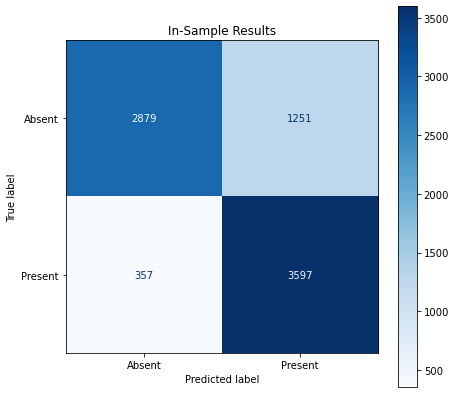

In [25]:
# Visualise the results in a confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(full_model, X, y, display_labels=['Absent', 'Present'], cmap='Blues')
disp.figure_.set_size_inches((7, 7))
disp.ax_.set_title('In-Sample Results')
plt.show()

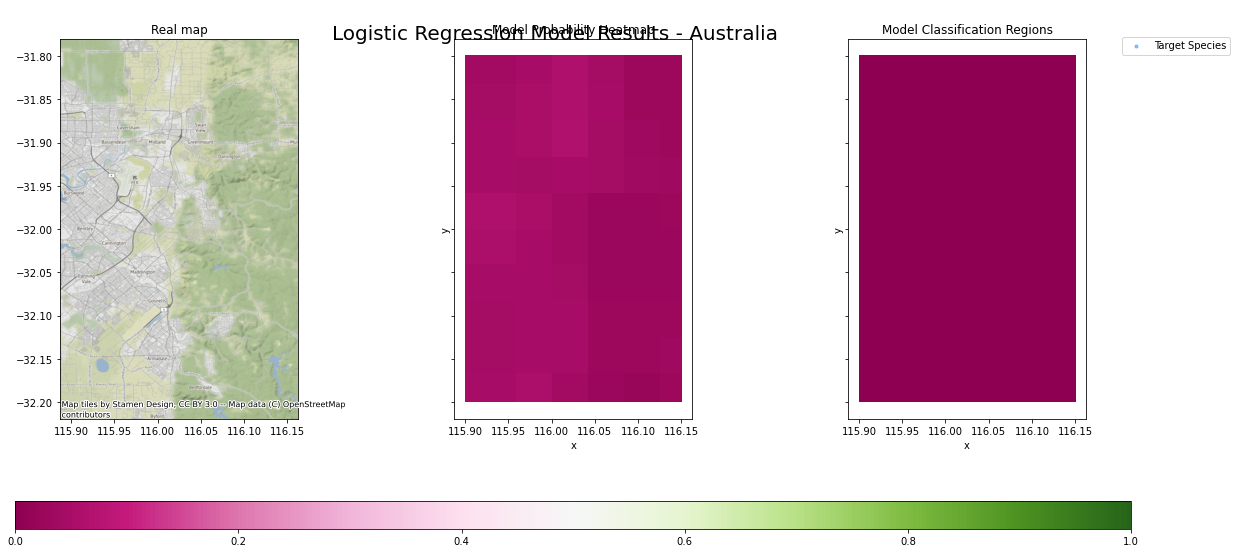

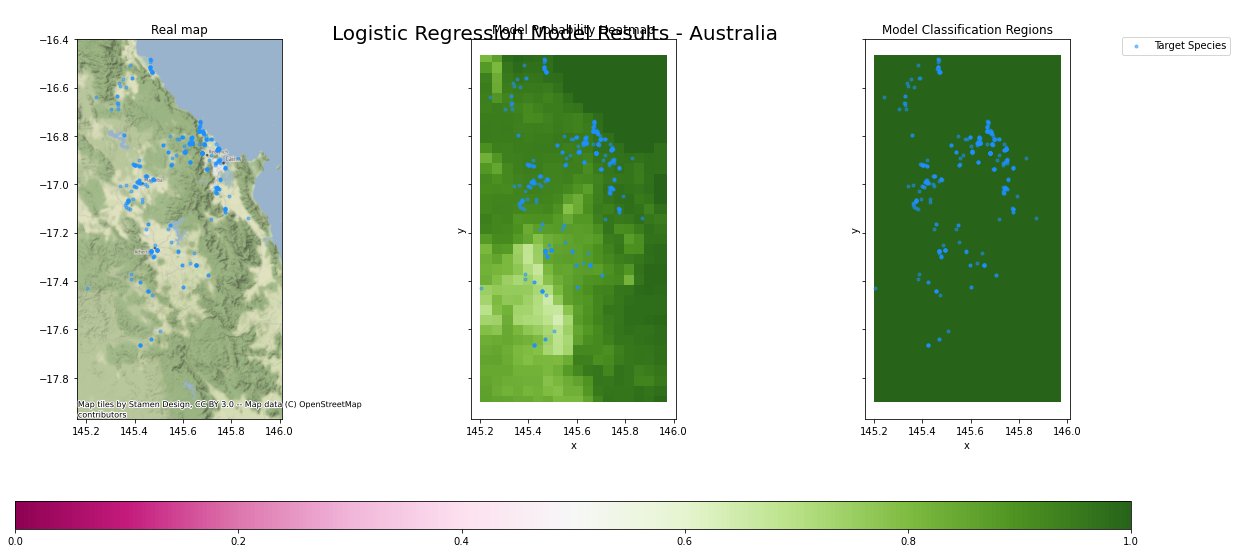

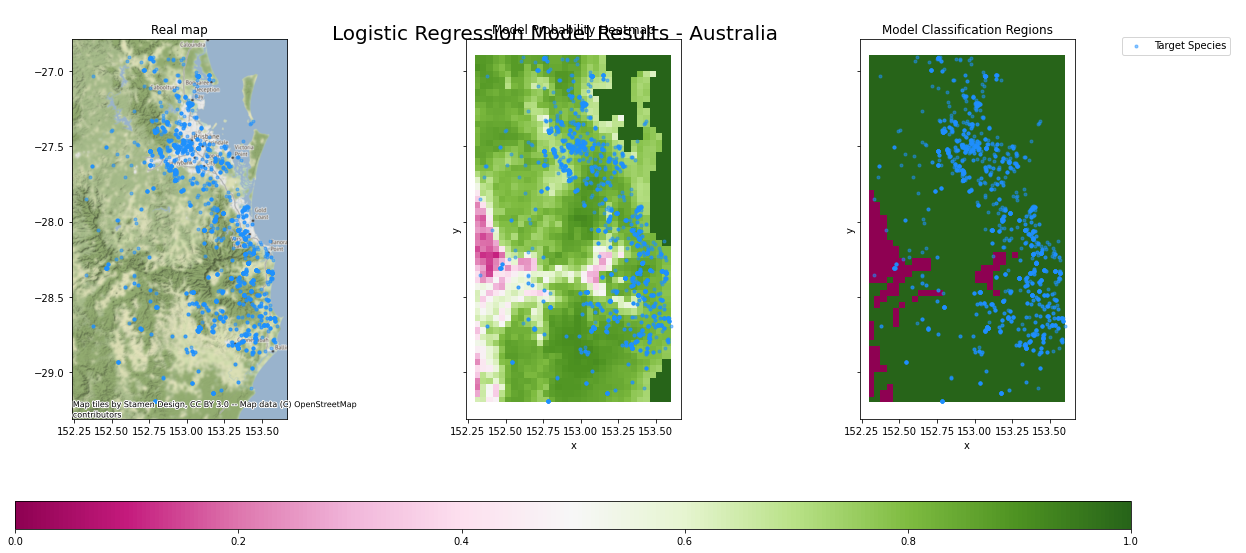

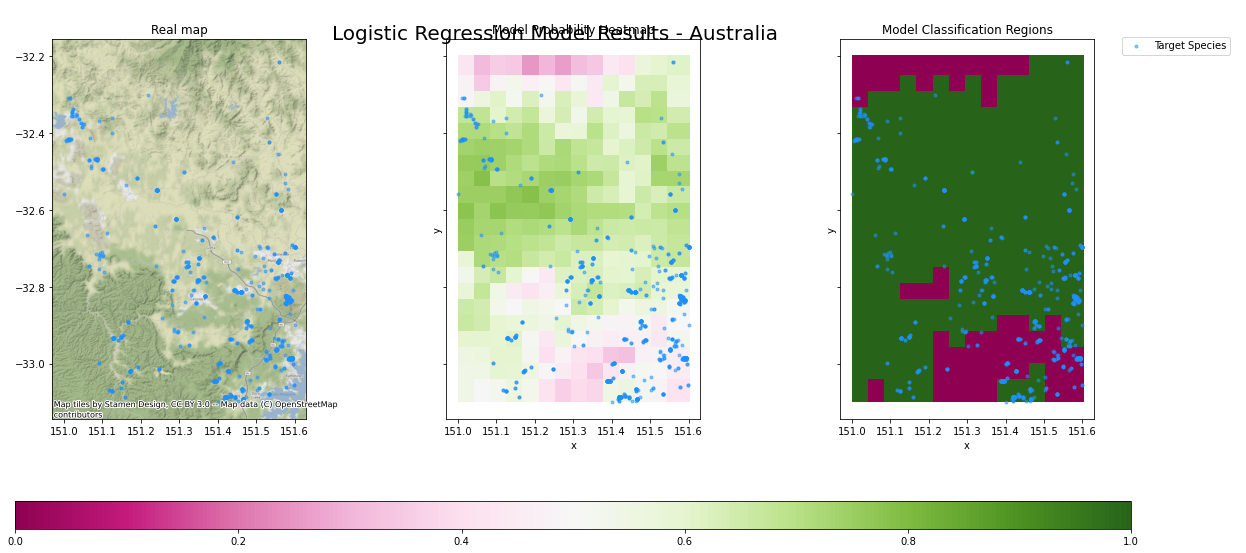

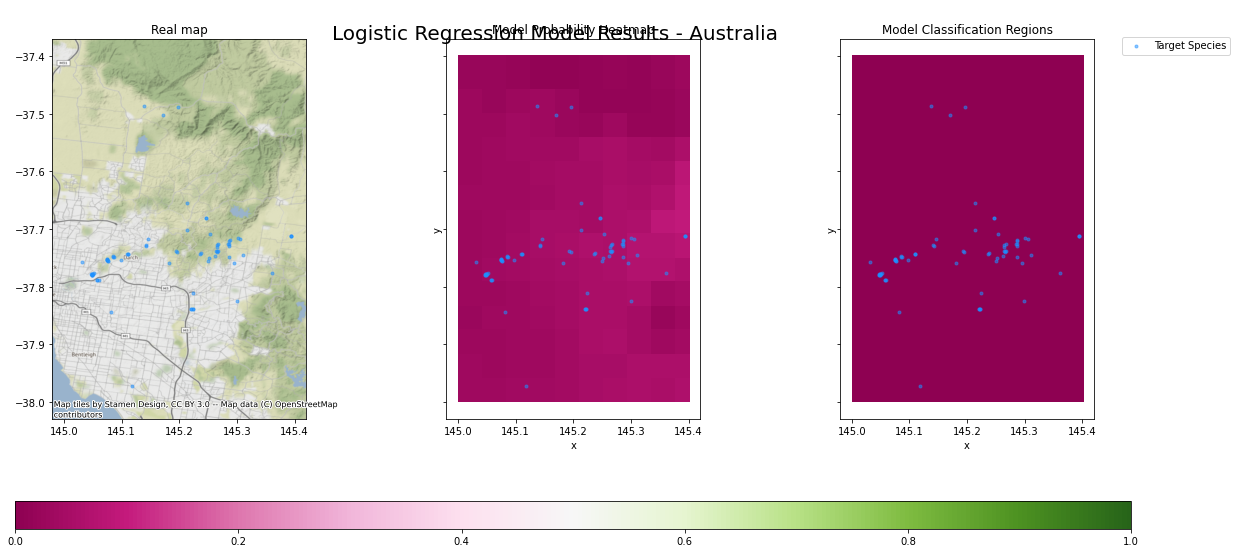

In [26]:
def plot_heatmap(resultant_image, frog_data, title, crs = {'init':'epsg:4326'}):
    """Plots a real map, probability heatmap, and model classification regions for the probability image from our model.

    Arguments:
    resultant_image -- (1, n, m) xarray of probabilities output from the model
    frog_data -- Dataframe of frog occurrences, indicated with a 1 in the occurrenceStatus column. 
                 Must contain ["occurrenceStatus", "decimalLongitude", "decimalLatitude"]
    title -- string that will be displayed as the figure title
    crs -- coordinate reference system for plotting the real map. Defaults to EPSG:4326.
    """
    fig, ax = plt.subplots(1, 3, figsize = (20, 10), sharex=True, sharey=True)
    extent = [resultant_image.x.min(),resultant_image.x.max(),resultant_image.y.min(),resultant_image.y.max()]
    cmap = 'PiYG'

    # Plot real map
    ax[0].scatter(x=[extent[0], extent[1]], y=[extent[2], extent[3]], alpha=0)
    cx.add_basemap(ax[0], crs=crs)
    ax[0].set_title('Real map')
    
    # Plot heatmap from model
    heatmap = resultant_image.plot.imshow(
        x='x', y='y', ax=ax[1], cmap=cmap, vmin=0, vmax=1, interpolation='none', add_colorbar=False
    )
    ax[1].set_aspect('equal')
    ax[1].set_title('Model Probability Heatmap')

    # Plot binary classification from model
    regions = xr.where(resultant_image.isnull(), np.nan, resultant_image>0.5).plot.imshow(
            x='x', y='y', ax=ax[2], cmap=cmap, vmin=0, vmax=1, interpolation='none', add_colorbar=False
    )
    ax[2].set_aspect('equal')
    ax[2].set_title('Model Classification Regions')

    # Plot real frogs
    for i, axis in enumerate(ax):
        filt = frog_data.occurrenceStatus == 1
        axis.scatter(
            frog_data[filt].decimalLongitude, frog_data[filt].decimalLatitude, 
            color = 'dodgerblue', marker='.', alpha=0.5, label='Target Species' if i==0 else ''
        )

    fig.colorbar(heatmap, ax=ax, location = 'bottom', aspect=40)
    fig.legend(loc = (0.9, 0.9))
    fig.suptitle(title, x=0.5, y=0.9, fontsize=20)
    

for (resultant_image,list_frog_df) in zip(resultant_images,list_frog_dfs):
    plot_heatmap(resultant_image, list_frog_df, f"Logistic Regression Model Results - {region_name}")

## Submission

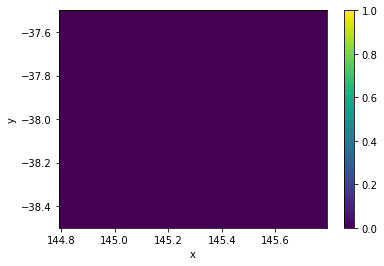

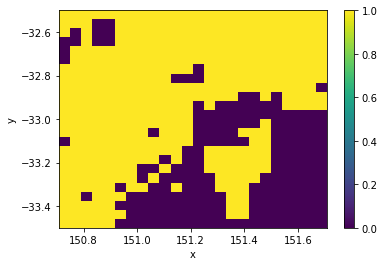

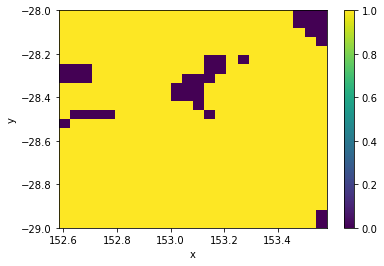

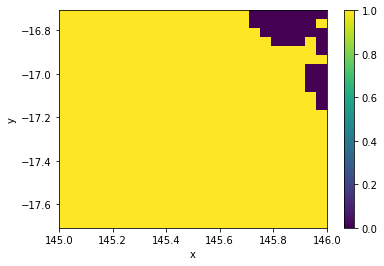

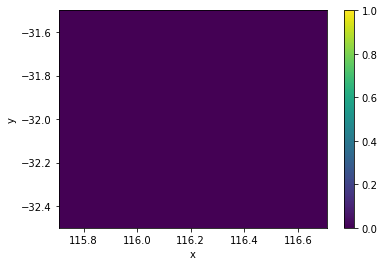

In [27]:
# Load in test coordinates
test_file = pd.read_csv('submission_template.csv')

# Read in test regions
test_1_regions = []
with open('test_regions.txt', 'r') as file: 
    for i, line in enumerate(file):
        if i > 0:
            test_1_regions.append(eval("("+line+")"))

# Load in regions and save as list of dictionaries.
test_regions = [{'title':i, 'bbox':bbox} for i, bbox in enumerate(test_1_regions)]

# Obtain predictor data for each region and get predictor image
for region in test_regions:
    region['coords'] = filter_bbox(test_file[['id', 'decimalLongitude', 'decimalLatitude']], region['bbox'])
    region['predictors'] = get_terraclimate(region['bbox'], tc_metrics, time_slice=time_slice, assets=assets, features=features)
    region['result'] = predict_frogs(region['predictors'], full_model) > 0.5
    
    region['result'].plot.imshow(x='x', y='y', vmin=0, vmax=1)
    plt.show()

In [28]:
predictions = pd.DataFrame()

for region in test_regions:
    preds = (
        region['result'].rename('occurrenceStatus')
        .sel(
            x=xr.DataArray(region['coords'].decimalLongitude, dims="id", coords={"id": region['coords'].id}), 
            y=xr.DataArray(region['coords'].decimalLatitude, dims="id", coords={"id": region['coords'].id}),
            method="nearest"
        )
        .to_dataframe()
        .reset_index()
        .rename(columns={'x':'decimalLongitude', 'y':'decimalLatitude'})
    )
    predictions = predictions.append(preds)
            
submission = (    
    predictions.merge(
        test_file, 
        on=['decimalLongitude', 'decimalLatitude'], 
        how='left', suffixes = ('', '_'))
    [test_file.columns]
    .fillna(0)
    .astype({col:'int' for col in test_file.columns[3::]})
)



In [29]:
display(submission)
# Save to output folder
for feat in to_k
subm_filename = '-'.join(to_keep)
submission.to_csv(subm_filename + '.csv', index=None)

SyntaxError: invalid syntax (3733758700.py, line 3)